In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoFeatureExtractor, AutoModelForAudioClassification, AutoModelForImageClassification
from facenet_pytorch import MTCNN # Our new face detector
from PIL import Image

from datasets import load_dataset, Audio
import numpy as np
import os
import cv2
import librosa
from tqdm.auto import tqdm

# Models for fusion
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("All libraries imported.")

All libraries imported.


In [2]:
# --- 1. Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Define Data Paths ---
DATA_DIR = '../data/MELD_processed/'
RAW_DATA_PATH = '../data/MELD_raw/MELD.Raw/'

# --- 3. Load "Master" Label Mappings ---
# We'll use the text dataset as our ground truth for labels
temp_dataset = load_dataset("csv", data_files={"train": os.path.join(DATA_DIR, 'train_text.csv')})["train"]
temp_dataset = temp_dataset.rename_column("emotion", "label")
temp_dataset = temp_dataset.class_encode_column("label")

labels_list = temp_dataset.features["label"].names
num_labels = len(labels_list)
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for i, label in enumerate(labels_list)}

print(f"Master labels loaded: {labels_list}")

# --- 4. Define our raw data video paths (for faces) ---
split_to_video_folder = {
    'train': 'train_splits',
    'val': 'dev_splits_complete', # Use 'val' for our dev set
    'test': 'output_repeated_splits_test'
}

Using device: cpu


Generating train split: 9988 examples [00:00, 262671.62 examples/s]
Casting to class labels: 100%|██████████████████████████████████████████| 9988/9988 [00:00<00:00, 262824.88 examples/s]

Master labels loaded: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


In [6]:
# --- 1. Load FER (Face) Model ---
fer_model_name = "trpakov/vit-face-expression"
fer_processor = AutoFeatureExtractor.from_pretrained(fer_model_name)
fer_model = AutoModelForImageClassification.from_pretrained(fer_model_name).to(device)
fer_model.eval()
print("✅ FER (Face) model loaded.")

# --- 2. Load SER (Audio) Model ---
ser_model_name = "superb/wav2vec2-base-superb-er"
ser_processor = AutoFeatureExtractor.from_pretrained(ser_model_name)
ser_model = AutoModelForAudioClassification.from_pretrained(
    ser_model_name,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
    use_safetensors=True
).to(device)

# --- FIX: Use map_location=device ---
ser_weights_path = '../models/ser_model_finetuned_weighted.pth'
ser_model.load_state_dict(torch.load(ser_weights_path, map_location=device)) # <-- ADDED map_location
ser_model.eval()
print("✅ SER (Audio) model loaded with fine-tuned weights.")

# --- 3. Load TER (Text) Model ---
ter_model_name = "cardiffnlp/twitter-roberta-base-emotion"
ter_tokenizer = AutoTokenizer.from_pretrained(ter_model_name)
ter_model = AutoModelForSequenceClassification.from_pretrained(
    ter_model_name,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
    use_safetensors=True
).to(device)

# --- FIX: Use map_location=device ---
ter_weights_path = '../models/ter_model_finetuned.pth'
ter_model.load_state_dict(torch.load(ter_weights_path, map_location=device)) # <-- ADDED map_location
ter_model.eval()
print("✅ TER (Text) model loaded with fine-tuned weights.")

# --- 4. Load Face Detector ---
# Initialize MTCNN
face_detector = MTCNN(device=device)
print("✅ Face Detector (facenet-pytorch) loaded.")

✅ FER (Face) model loaded.


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ SER (Audio) model loaded with fine-tuned weights.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ TER (Text) model loaded with fine-tuned weights.
✅ Face Detector (facenet-pytorch) loaded.


In [7]:
import torch.nn.functional as F

# --- FER Prediction Function ---
def get_fer_prediction(image):
    # Image should be a PIL Image
    try:
        inputs = fer_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = fer_model(**inputs).logits
        # Convert logits to probabilities
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
    except Exception:
        probs = np.full(num_labels, 1/num_labels) # Return uniform prob if face fails
    return probs

# --- SER Prediction Function ---
def get_ser_prediction(audio_array):
    try:
        inputs = ser_processor(
            audio_array,
            sampling_rate=16000,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = ser_model(**inputs).logits
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
    except Exception:
        probs = np.full(num_labels, 1/num_labels)
    return probs

# --- TER Prediction Function ---
def get_ter_prediction(text):
    try:
        inputs = ter_tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)
        with torch.no_grad():
            logits = ter_model(**inputs).logits
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()
    except Exception:
        probs = np.full(num_labels, 1/num_labels)
    return probs

# --- Face Extractor Function ---
def get_face(video_path):
    try:
        cap = cv2.VideoCapture(video_path)
        # Get middle frame
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
        success, frame = cap.read()
        cap.release()
        
        if success:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_pil = Image.fromarray(frame_rgb)
            # Use facenet-pytorch to detect
            boxes, _ = face_detector.detect(frame_pil)
            if boxes is not None:
                # Get the box with the highest probability
                box = boxes[0]
                # Crop the face
                face_image = frame_pil.crop(box)
                return face_image
    except Exception:
        return None
    return None

print("✅ Helper functions defined.")

✅ Helper functions defined.


In [9]:
# --- Load the VAL/DEV dataset ---
val_dataset = load_dataset("csv", data_files={"val": os.path.join(DATA_DIR, 'dev_text.csv')})["val"]
# Cast to our master labels
val_dataset = val_dataset.rename_column("emotion", "label")
val_dataset = val_dataset.class_encode_column("label")
val_dataset = val_dataset.cast_column("label", temp_dataset.features["label"])

print(f"Generating fusion training set from {len(val_dataset)} validation samples...")

fusion_features_train = []
fusion_labels_train = []

for item in tqdm(val_dataset):
    # 1. Get True Label
    true_label = item["label"]
    
    # --- 2. Get Raw Data ---
    text = item["text"]
    # Load audio
    audio, sr = librosa.load(item["audio_path"], sr=16000)
    # Get video path
    dia_id, utt_id = item["audio_path"].split('/')[-1].replace('.wav', '').replace('dia', '').split('_utt')
    video_path = os.path.join(RAW_DATA_PATH, 'dev', split_to_video_folder['val'], f"dia{dia_id}_utt{utt_id}.mp4")
    
    # --- 3. Get Face Image ---
    face_image = get_face(video_path)
    
    # --- 4. Get Predictions from all 3 models ---
    fer_probs = get_fer_prediction(face_image) # 7 numbers
    ser_probs = get_ser_prediction(audio)     # 7 numbers
    ter_probs = get_ter_prediction(text)      # 7 numbers
    
    # --- 5. Concatenate Features ---
    # Our new feature is a 21-number vector (7+7+7)
    final_features = np.concatenate([fer_probs, ser_probs, ter_probs])
    
    fusion_features_train.append(final_features)
    fusion_labels_train.append(true_label)

# Convert to NumPy arrays for sklearn
X_train = np.array(fusion_features_train)
y_train = np.array(fusion_labels_train)

print(f"✅ Fusion training set created. Shape: {X_train.shape}")

Generating fusion training set from 1108 validation samples...


100%|██████████████████████████████████████████████████████████████████████████████| 1108/1108 [03:22<00:00,  5.46it/s]

✅ Fusion training set created. Shape: (1108, 21)


In [10]:
# --- 1. Scale Features ---
# Scale features to have 0 mean and 1 variance (good for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# --- 2. Train Fusion Model ---
print("Training fusion 'meta-model'...")
fusion_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
fusion_model.fit(X_train_scaled, y_train)

print("✅ Fusion model trained.")

# --- 3. Check Accuracy on the data we trained on (just a sanity check) ---
y_pred_train = fusion_model.predict(X_train_scaled)
train_acc = accuracy_score(y_train, y_pred_train)
print(f"Fusion model accuracy (on val set): {train_acc*100:.2f}%")

Training fusion 'meta-model'...
✅ Fusion model trained.
Fusion model accuracy (on val set): 63.27%


C:\Users\sharm\.conda\envs\trisense_v2\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Generating fusion test set from 2610 test samples...


100%|██████████████████████████████████████████████████████████████████████████████| 2610/2610 [08:47<00:00,  4.95it/s]


✅ Fusion test set created. Shape: (2610, 21)

--- 🚀 FINAL PROJECT RESULTS 🚀 ---

--- Final Classification Report (Late Fusion) ---
              precision    recall  f1-score   support

       anger       0.48      0.47      0.48       345
     disgust       0.47      0.12      0.19        68
        fear       0.19      0.18      0.19        50
         joy       0.60      0.61      0.61       402
     neutral       0.76      0.84      0.80      1256
     sadness       0.49      0.33      0.39       208
    surprise       0.59      0.60      0.60       281

    accuracy                           0.66      2610
   macro avg       0.51      0.45      0.46      2610
weighted avg       0.64      0.66      0.64      2610

Plotting final confusion matrix...


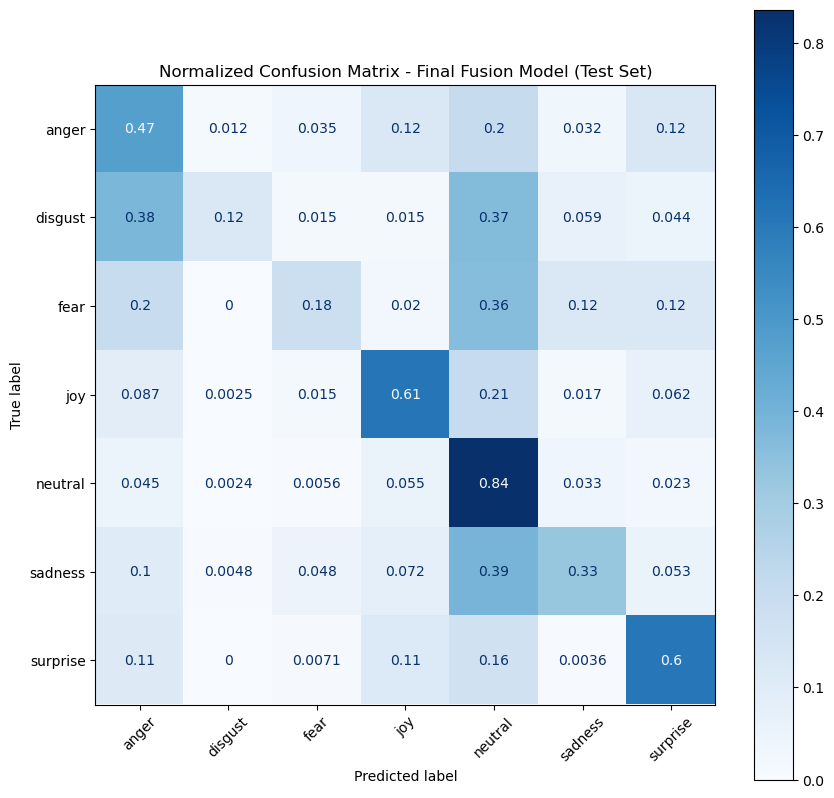

In [12]:
# --- 1. Load the TEST dataset ---
test_dataset = load_dataset("csv", data_files={"test": os.path.join(DATA_DIR, 'test_text.csv')})["test"]
test_dataset = test_dataset.rename_column("emotion", "label")
test_dataset = test_dataset.class_encode_column("label")
test_dataset = test_dataset.cast_column("label", temp_dataset.features["label"])

print(f"Generating fusion test set from {len(test_dataset)} test samples...")

fusion_features_test = []
fusion_labels_test = []

for item in tqdm(test_dataset):
    # 1. Get True Label
    true_label = item["label"]
    
    # --- 2. Get Raw Data ---
    text = item["text"]
    audio, sr = librosa.load(item["audio_path"], sr=16000)
    dia_id, utt_id = item["audio_path"].split('/')[-1].replace('.wav', '').replace('dia', '').split('_utt')
    video_path = os.path.join(RAW_DATA_PATH, 'test', split_to_video_folder['test'], f"dia{dia_id}_utt{utt_id}.mp4")
    
    # --- 3. Get Face Image ---
    face_image = get_face(video_path)
    
    # --- 4. Get Predictions from all 3 models ---
    fer_probs = get_fer_prediction(face_image)
    ser_probs = get_ser_prediction(audio)
    ter_probs = get_ter_prediction(text)
    
    # --- 5. Concatenate Features ---
    final_features = np.concatenate([fer_probs, ser_probs, ter_probs])
    
    fusion_features_test.append(final_features)
    fusion_labels_test.append(true_label)

# Convert to NumPy arrays for sklearn
X_test = np.array(fusion_features_test)
y_test = np.array(fusion_labels_test)

print(f"✅ Fusion test set created. Shape: {X_test.shape}")

# --- 6. Run Final Evaluation ---
print("\n--- 🚀 FINAL PROJECT RESULTS 🚀 ---")
# Use the scaler we already 'fit' on the training data
X_test_scaled = scaler.transform(X_test)

# Get final predictions
y_pred_test = fusion_model.predict(X_test_scaled)

# --- 7. Print Report and Confusion Matrix ---
print("\n--- Final Classification Report (Late Fusion) ---")
print(classification_report(y_test, y_pred_test, target_names=labels_list))

print("Plotting final confusion matrix...")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    display_labels=labels_list,
    cmap='Blues',
    normalize='true',
    ax=ax,
    xticks_rotation=45
)
ax.set_title('Normalized Confusion Matrix - Final Fusion Model (Test Set)')
plt.show()